# Approfondissement ElasticSearch pour des recherches de proximité

géographique

Pour essayer les exemples présents dans ce tutoriel :

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modern-ds/elastic_approfondissement.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter.png)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modern-ds/elastic_approfondissement.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter.png)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/modern-ds/elastic_approfondissement.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python.png)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABnotebooks/course/modern-ds%20elastic_approfondissement.ipynb%C2%BB&security.allowlist.enabled=false)<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=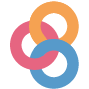.png)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=notebooks/course/modern-ds/elastic_approfondissement.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/modern-ds/elastic_approfondissement.ipynb)
[![githubdev](https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc.png)](https://github.dev/linogaliana/python-datascientist/notebooks/course/modern-ds/elastic_approfondissement.ipynb)

Ce chapitre est issu du travail produit
dans le cadre d’un hackathon de l’Insee avec
[Raphaële Adjerad](https://github.com/raphaeleadjerad)
et présente quelques éléments qui peuvent être utiles
pour l’enrichissement de données d’entreprises
à partir d’un répertoire officiel.

:warning: Il nécessite une version particulière du package `elasticsearch` pour tenir compte de l’héritage de la version 7 du moteur Elastic. Pour cela, faire

``` python
pip install elasticsearch==8.2.0
```

# Introduction

## Réplication de ce chapitre

Comme le précédent, ce chapitre est plus exigeant en termes d’infrastructures que les précédents.
Il nécessite un serveur Elastic. Les utilisateurs du
[SSP Cloud](datalab.sspcloud.fr/) pourront répliquer les exemples de ce cours
car cette technologie est disponible (que ce soit pour indexer une base ou
pour requêter une base existante).

La première partie de ce tutoriel, qui consiste à créer une base Sirene géolocalisée
à partir des données *open-data* ne nécessite pas d’architecture particulière et
peut ainsi être exécutée en utilisant les packages suivants:

In [2]:
import time
import numpy as np
import pandas as pd